<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Code for Prolific Analysis</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">LEIA vs. Humans - Masterthesis</h4>
</div>
<br>

In [1]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.stats.contingency_tables import mcnemar

from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import Counter

import numpy as np
from transformers import pipeline
import random
from tqdm import tqdm
import pandas as pd
import json

import colorsys
import matplotlib.colors as mcolors

import math
import matplotlib.patches as mpatches

In [2]:
emotions = ["Anger", "Fear", "Happiness", "Sadness"]


In [8]:
# file paths containing results downloaded from prolific

file_path_results = 'prolific_results/experiment1/sentiments_annotations/annotated_instances.json'
file_path_results_missing = 'prolific_results/experiment1-missing/sentiments_annotations/annotated_instances.json'
file_path_results_missing2 = 'prolific_results/experiment1-missing2/sentiments_annotations/annotated_instances.json'


question_batch_path = "question_batch/safe_final_sample.csv"


In [9]:
added_rows = pd.read_csv('C:/Users/clair/Documents/Master/Thesis/Data/potato_data/experiment1_added_rows.csv')

## Step 1: Preprocessing

In [10]:
def load_prolific_answers(file_path):
    """load full file of annotated instances from prolific data

    Args:
        file_path (str): file conatining prolific answers

    Returns:
        list: list of data items
    """
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line.strip()))

    return data

In [11]:

# Experiment 1 - actual run + missing annotations per text

data = load_prolific_answers(file_path_results)
data_missing = load_prolific_answers(file_path_results_missing)
data_missing2 = load_prolific_answers(file_path_results_missing2)




added_text_rows = set(added_rows['text'])

filtered_data_missing = [
    entry for entry in data_missing
    if entry['displayed_text'] not in added_text_rows
]


len(filtered_data_missing)

text_to_instance_id = {
    entry['displayed_text']: entry['instance_id']
    for entry in data
}

for entry in filtered_data_missing:
    text = entry['displayed_text']
    if text in text_to_instance_id:
        entry['instance_id'] = text_to_instance_id[text]

for entry in data_missing2:
    text = entry['displayed_text']
    if text in text_to_instance_id:
        entry['instance_id'] = text_to_instance_id[text]



data.extend(filtered_data_missing)
data.extend(data_missing2)

In [12]:
def extract_info(data):
    """
    Generate different dataframe structure from prolific data

    Args:
        data (list): list of prolific data elements

    Returns:
        text_annotator_df (df): dataframe with column per participant
        annotators (list): list of all annotator ids participating in study
        annotator_df (df): dataframe row per individual annotation
        aggregated_emotions (df): dataframe of aggregated votes per text
    """
    rows = []
    annotators = []

    for entry in data:
        #extracting relevant information
        user_id = entry['user_id']
        text = entry['displayed_text']
        sentiment_labels = entry['label_annotations'].get('sentiment', {})
        instance_id = entry['instance_id']

        # add individual annotators to list
        if user_id not in annotators:
            annotators.append(user_id)

        # create individual rows
        for sentiment, value in sentiment_labels.items():
            rows.append({'text': text, 'user_id': user_id,'instance_id': instance_id, 'label': f"{sentiment}"})

    df = pd.DataFrame(rows)
    text_annotator_df = df.pivot_table(index=['instance_id', 'text'], columns='user_id', values='label', aggfunc=lambda x: ', '.join(x)).reset_index()

    # majority vote
    aggregated_emotions = df.groupby(['instance_id', 'text', 'label']).size().unstack(fill_value=0).reset_index()
    aggregated_emotions.insert(5, 'annotation_count',  aggregated_emotions[['Anger', 'Fear', 'Happiness', 'Sadness']].sum(axis=1))



    return text_annotator_df, annotators, df, aggregated_emotions

overall_results, annotators , annotator_df, agg = extract_info(data)


In [13]:

def remove_test_untrustwothy_users(df, annotator_df, annotators=annotators):

    """
    Remove particicpants that failed to answer the test questions correctly

    Args: 
        df : dataframe with particpants as columns
        annotator_df : dataframe with participants as rows
        annotators: list of individual annotators
    
    Returns:
        dataframes and lists: removed annotators and dataframes without annotations of untrustworthy participants
    """
    wrong_users = []

    correct_labels = {
        "0_testing": "Happiness",
        "1_testing": "Sadness"
    }

    test_rows = df[df['instance_id'].isin(correct_labels.keys())]

    # Loop over user columns (skip ['user_id', 'instance_id', 'text'])
    for user_id in df.columns[3:]:
        incorrect = False

        # Check each test row manually
        for idx, row in test_rows.iterrows():
            instance = row['instance_id']
            correct_label = correct_labels[instance]
            user_answer = row[user_id]

            if str(user_answer).strip() != correct_label:
                incorrect = True
                break  
        if incorrect:
            wrong_users.append(user_id)

    
    trustw_anno = list(set(annotators) - set(wrong_users))


    df_trustw_users = df.drop(columns=wrong_users, errors='ignore').dropna(how='all', subset=trustw_anno)


    results_wo_test_q = df_trustw_users[~df_trustw_users['instance_id'].isin(['0_testing', '1_testing'])].reset_index(drop=True)#.drop(columns='sentiment')

    trustw_anno_df = annotator_df[~annotator_df['user_id'].isin(wrong_users)]

    
    aggregated_emotions = trustw_anno_df.groupby(['instance_id', 'text', 'label']).size().unstack(fill_value=0).reset_index()
    aggregated_emotions.insert(6, 'annotation_count',  aggregated_emotions[['Anger', 'Fear', 'Happiness', 'Sadness']].sum(axis=1))

    trustw_anno_df = trustw_anno_df.loc[~((annotator_df['instance_id']=='1_testing') | (trustw_anno_df['instance_id']=='0_testing'))]

    
    
    # Remove test questions from the emotion counts DataFrame as well
    aggregated_emotions = aggregated_emotions[~aggregated_emotions['instance_id'].isin(['0_testing', '1_testing'])].reset_index(drop=True)

    return results_wo_test_q, aggregated_emotions, trustw_anno, wrong_users, trustw_anno_df


cleaned_df, cleaned_agg_emot, annotators, failed_test, annotator_df = remove_test_untrustwothy_users(overall_results, annotator_df)

In [14]:
len(annotators)

201

In [15]:
# code for basic analysis of answers - counting texts per participant

annotator_counts = {annotator: cleaned_df[annotator].count() for annotator in annotators}

sorted_annotators = sorted(annotator_counts.items(), key=lambda x: x[1], reverse=True)

for annotator, count in sorted_annotators:
    print(f"{annotator}: {count}")


678c89e7d72ecd785f475dfd: 29
67e879fe11e09af6fae79aaf: 28
63ebd39a63bb79b50d438ab7: 25
66f934cc14ae5ebdcd94b1d8: 25
600f9342e7bc5518fa9ca92a: 25
5c2cf8a7be4e9200014fc062: 25
67811c4fdaa9119f0fe31fca: 25
62db2644ab0a3a353c0dcb54: 25
5c388683fb3f0f0001fdf65a: 25
677843bffe966e4dc7f484b3: 25
66fd4b51cb041accd82a7740: 25
612df482fb26d2d8dab91688: 25
655e09fc282e4139c82f834a: 25
64db80772c860983ea3a7310: 25
67d9d158b3db2c7d641840b0: 25
66b77a4d4619216a83b90caf: 25
60c969c12749ced10866921d: 25
669a67432f97ada112dd9c21: 25
67be9cc9db559147a6f5a9d7: 25
5ef7204033605901ce86c0b0: 25
67d9a7fc592e7d34740eeca9: 25
5ef877bb6b0ed15b3f6ae106: 25
67612c302f90b2399522a2ba: 25
62b351e5ffccd9a25a047464: 25
67f08fe4e63319ca9198955f: 25
659d6e087606f95235236d8e: 25
573b8bc2f3580b0006ce0986: 25
677e711cdae0199f19d68029: 25
62d793b216e1b007c88f156f: 25
5c23c03889f035000173d7d7: 25
6765829a949d1203926e1ade: 25
6723fefd7a09fe9da8f9bd10: 25
6583287e9845b219549fb80b: 25
668aa0851622bf0930ff12fc: 25
6823f22faff063

In [16]:
# counting distribution of texts per annotator

annotator_counts = {annotator: cleaned_df[annotator].count() for annotator in annotators}

count_distribution = Counter(annotator_counts.values())

for count, num_annotators in sorted(count_distribution.items(), reverse=True):
    print(f"{num_annotators} annotator(s) annotated {count} texts")


1 annotator(s) annotated 29 texts
1 annotator(s) annotated 28 texts
185 annotator(s) annotated 25 texts
10 annotator(s) annotated 24 texts
2 annotator(s) annotated 23 texts
1 annotator(s) annotated 22 texts
1 annotator(s) annotated 10 texts


In [ ]:
print(len(failed_test))

failed_test

In [18]:
def combine_ground_truth(result, question_batch_file:str):
    
    """ Combines answers from prolific with ground truth of each text

    Args:
        result (df): dataframe to be combined with ground truth
        question_batch_file (str): path to original question file
    

    Returns:
        df: dataframe strutcured as before input, including ground truth
    """
    question_batch = pd.read_csv(question_batch_file)
    annotation_ground_truth = result.merge(question_batch, how='left', on='text')

    return annotation_ground_truth.drop(columns = ['id']).rename(columns={'sentiment': 'true_label'})

comparison_df = combine_ground_truth(cleaned_df, question_batch_path)
comparison_agg_emot = combine_ground_truth(cleaned_agg_emot, question_batch_path)
annotator_df = combine_ground_truth(annotator_df, question_batch_path)



In [19]:
# check if annotations are missing
missing = cleaned_agg_emot[cleaned_agg_emot['annotation_count']<5]

In [21]:
# potato needs a specific structure

# function to create a data set for potato from sample created in preprocessing
test_df = pd.read_csv('question_batch/test_questions.csv')


def create_potato_data(data, name:str, test_df, current_project:str = ''):
    data = data.copy().reset_index()  
    
    for i in range(len(data)):
        data.at[i, 'id'] = f'item_{i+1}'  

    result = pd.concat([data, test_df]).drop(columns = ['index'])    

    result.to_csv(f'../potato_data/{name}.csv', index = False)
    return result 

if len(missing) > 0:



    create_potato_data(missing, 'experiment1-missing2', test_df)


In [22]:

def majority_calculation(df, label_cols=emotions):
    """caluclate majority vote fro 5 annotations per text

    Args:
        df (dataframe): dataframe containing aggreagted answers per text
        label_cols (list, optional): columsn of aggragted answers per text. Defaults to emotions.
    """
    def find_max(row):
        max_count = row[label_cols].max()
        max_cols = [col for col in label_cols if row[col] == max_count]
        return random.choice(max_cols) if len(max_cols) > 1 else max_cols[0]
    

    df['annotator_majority'] = df.apply(find_max, axis=1)
    
    return df

anno_maj_aggr_emot = majority_calculation(comparison_agg_emot)


In [23]:
def check_text_type_distribution_per_user(df):
    """Check distribution of emotions of participants samples,
    Used to check how skewed distribution of emotion is.

    Args:
        df (dataframe): dataframe with annotator as rows
    """
    users = df['user_id'].unique()
    for user in users:
        user_data = df[df['user_id'] == user]
        counts = user_data['label'].value_counts()
        
        print(f"User {user} text type counts:")
        print(counts)
        print('-' * 40)

check_text_type_distribution_per_user(annotator_df)

User 64011ddd299336698fa0c488 text type counts:
label
Sadness      9
Anger        7
Fear         7
Happiness    2
Name: count, dtype: int64
----------------------------------------
User 6658b2d717b161dc426bd193 text type counts:
label
Happiness    8
Sadness      7
Anger        7
Fear         3
Name: count, dtype: int64
----------------------------------------
User 5cc492b6155841001a26c24a text type counts:
label
Anger        8
Happiness    8
Sadness      7
Fear         2
Name: count, dtype: int64
----------------------------------------
User 67649dcb994250f1af5a1f4e text type counts:
label
Happiness    10
Sadness       7
Anger         4
Fear          4
Name: count, dtype: int64
----------------------------------------
User 67529d0aecb73bfe140d521f text type counts:
label
Anger        8
Sadness      7
Happiness    7
Fear         3
Name: count, dtype: int64
----------------------------------------
User 67d9a7fc592e7d34740eeca9 text type counts:
label
Sadness      9
Happiness    8
Anger  

## Step 2: Statistical Analysis

### 2.1 Accuracy, Precision, Recall, F1-Score

### 2.1.2 Metrics Differentiating between individuals

In [24]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score


In [25]:
def metrics_per_user(df, annotators=annotators, emotions=emotions):

    """Calculated a range of metrics per annotator. (Precision, Recall, F1, Accuracy, etc.)

    Returns:
        metrics_per_annotator: dataframe with all metrics per emotion
        macro_f1_anno: macro f1_score per annotator
        avg_per_emot: average of all per emotion.
    """

    results = []
    macro_f1s = {}

    for annotator in annotators:
        valid_rows = df[df[annotator].notna()]

        macro_f1s[annotator] = [f1_score(valid_rows['true_label'], valid_rows[annotator], labels=emotions, average='weighted'), f1_score(valid_rows['true_label'], valid_rows['Leia_Label'], labels=emotions, average='weighted')]

        
        for emotion in emotions:
            prec, rec, fbeta, supp= precision_recall_fscore_support(valid_rows['true_label'], valid_rows[annotator], labels=[emotion], zero_division = 0 )
            leia_prec, leia_rec, leia_fbeta, leia_supp= precision_recall_fscore_support(valid_rows['true_label'], valid_rows['Leia_Label'], labels=[emotion], zero_division = 0 )

            acc = accuracy_score(valid_rows['true_label'], valid_rows[annotator])
            b_acc = balanced_accuracy_score(valid_rows['true_label'], valid_rows[annotator])
            b_acc_leia = balanced_accuracy_score(valid_rows['true_label'], valid_rows['Leia_Label'])
            #f_leia = f1_score(valid_rows['true_label'], valid_rows['Leia_Label'], labels=[emotion], average='macro')

            results.append({
                "Annotator": annotator,
                "Emotion": emotion,
                "Accuracy": acc,
                "Balanced-accuracy": b_acc,
                "Balanced-accuracy Leia": b_acc_leia,
                "Precision": prec[0],
                "Recall": rec[0],
                "F1-score": fbeta[0],
                "Leia_Precision": leia_prec[0],
                "Leia_Recall": leia_rec[0],
                "Leia_F1": leia_fbeta[0], 
                "Support": supp[0]


            })

    macro_f1_anno = pd.DataFrame.from_dict(macro_f1s, orient='index', columns=['Macro F1-score', 'Leia Macro']).reset_index().rename(columns={'index':'Annotator'})
    result = pd.DataFrame(results)
    avg_emot = result.groupby("Emotion")[["Precision", "Recall", "F1-score","Leia_Precision", "Leia_Recall", "Leia_F1"]].mean().reset_index()

    return result, macro_f1_anno, avg_emot

metrics_per_annotator, macro_f1_anno, avg_per_emot = metrics_per_user(comparison_df)

In [26]:
avg_per_emot

,Emotion,Precision,Recall,F1-score,Leia_Precision,Leia_Recall,Leia_F1
0,Anger,0.581086,0.600619,0.566191,0.687143,0.750458,0.701074
1,Fear,0.641438,0.418639,0.478943,0.787699,0.636952,0.681039
2,Happiness,0.813200,0.860342,0.822675,0.937149,0.897835,0.910139
3,Sadness,0.518584,0.656467,0.555434,0.688402,0.783208,0.711504


In [28]:
macro_f1_anno

,Annotator,Macro F1-score,Leia Macro
0,63ebd39a63bb79b50d438ab7,0.506348,0.592381
1,66f934cc14ae5ebdcd94b1d8,0.685714,0.722968
2,600f9342e7bc5518fa9ca92a,0.583111,0.812571
3,5c2cf8a7be4e9200014fc062,0.722540,0.794872
4,67811c4fdaa9119f0fe31fca,0.592714,0.804444
...,...,...,...
196,675849848f0cf4eebe7cbfc7,0.537255,0.706667
197,67d0971411da4a743278e0e5,0.457143,0.627692
198,65313bdcb9fd825a8c1d4981,0.626286,0.712000
199,681a93530b87b32382b6515f,0.804278,0.805707


In [356]:
macro_f1_anno['better'] = macro_f1_anno.apply(
    lambda x: "Human" if x['Macro F1-score'] > x['Leia Macro'] else (
        "Identical" if x['Macro F1-score'] == x['Leia Macro'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator['F1-better'] = metrics_per_annotator.apply(
    lambda x: "Human" if x['F1-score'] > x['Leia_F1'] else (
        "Identical" if x['F1-score'] == x['Leia_F1'] else "Leia"
    ),
    axis=1
)

metrics_per_annotator['Balanced-accuracy-better'] = metrics_per_annotator.apply(lambda x: "LEIA" if x['Balanced-accuracy'] < x['Balanced-accuracy Leia'] else "Human", axis = 1)



metrics_per_annotator.groupby('Emotion')['F1-better'].value_counts()

Emotion    F1-better
Anger      Leia         152
           Human         36
           Identical     13
Fear       Leia         162
           Human         29
           Identical     10
Happiness  Leia         127
           Identical     48
           Human         26
Sadness    Leia         160
           Human         29
           Identical     12
Name: count, dtype: int64

In [357]:
metrics_per_annotator['F1-better'].value_counts()

F1-better
Leia         601
Human        120
Identical     83
Name: count, dtype: int64

In [358]:
macro_f1_anno['better'].value_counts()

better
Leia         183
Human         17
Identical      1
Name: count, dtype: int64

In [359]:
# for descriptive analysis

pivot_df = metrics_per_annotator.pivot(index="Annotator", columns="Emotion", values="F1-better")

human_win_mask = pivot_df == "Human"

annotators_who_won_all = human_win_mask[human_win_mask.all(axis=1)].index.tolist()

annotators_who_won_some = human_win_mask[human_win_mask.any(axis=1)].index.tolist()

human_win_counts = human_win_mask.sum(axis=1).sort_values(ascending=False)

summary_df = human_win_mask.copy()
summary_df["Total_Human_Wins"] = human_win_counts

win_summary = human_win_counts.value_counts().sort_index().reset_index()
win_summary.columns = ["Num_Emotions_Human_Better", "Num_Annotators"]

full_range = pd.DataFrame({"Num_Emotions_Human_Better": range(len(pivot_df.columns)+1)})
win_summary = full_range.merge(win_summary, on="Num_Emotions_Human_Better", how="left").fillna(0).astype(int)

print("\n=== Annotator → Number of Emotions Where Human Was Better ===")
print(summary_df["Total_Human_Wins"].value_counts().sort_index())

print("\n=== Distribution: # Annotators Beating Leia in N Emotions ===")
print(win_summary)





=== Annotator → Number of Emotions Where Human Was Better ===
Total_Human_Wins
0    114
1     61
2     20
3      5
4      1
Name: count, dtype: int64

=== Distribution: # Annotators Beating Leia in N Emotions ===
   Num_Emotions_Human_Better  Num_Annotators
0                          0             114
1                          1              61
2                          2              20
3                          3               5
4                          4               1


In [360]:
print(f"Annotators who beat Leia in ALL emotions: {len(annotators_who_won_all)}")
print(f"Annotators who beat Leia in ANY emotion: {len(annotators_who_won_some)}")

print("\nTop annotators by number of emotions they beat Leia in:")
print(human_win_counts.head(10))


Annotators who beat Leia in ALL emotions: 1
Annotators who beat Leia in ANY emotion: 87

Top annotators by number of emotions they beat Leia in:
Annotator
66fd4b51cb041accd82a7740    4
5e86c11942701c2ffda5d113    3
67139698ab79b82f8afd1e93    3
6156fef09d1ab07148870099    3
5a068d5b074b190001251791    3
63c80a427dfa1305502df5a8    3
6575c7da000442e5a54f5e24    2
5ec1129f45a5365297e63600    2
5ef7204033605901ce86c0b0    2
6062450c1bb2c6f42298bda8    2
dtype: int64


In [361]:

def scatter_paired_emotions(df, s=20, alpha=1):
    """Create a paired scatter plot of F1_score per emotion for LEIA and Humans. 

    Args:
        df (dataframe): metrics per annotator
        s (int, optional): size of dots. Defaults to 20.
        alpha (int, optional): color fill value. Defaults to 1.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes = axes.flatten()

    

    for i, emotion in enumerate(emotions):
        ax = axes[i]
        emotion_df = df[df['Emotion'] == emotion]

        ax.scatter(emotion_df['F1-score'], emotion_df['Leia_F1'], alpha=alpha, s=s, color='orange')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        
        better_count = (emotion_df['F1-score'] > emotion_df['Leia_F1']).sum()
        total = len(emotion_df)
        percentage = better_count / total * 100
        
        # Annotate on plot
        ax.annotate(f'Human better: {better_count}/{total} ({percentage:.1f}%)',
                    xy=(0.05, 0.92), xycoords='axes fraction', fontsize=15,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))

        ax.set_xlabel("Human F1", fontsize = 20)
        ax.set_ylabel("Leia F1", fontsize = 20)
        ax.set_title(f"{emotion}")
        ax.grid(True)


    plt.tight_layout()
    plt.show()




{'Anger': '#d62728', 'Fear': '#2ca02c', 'Happiness': '#ff7f0e', 'Sadness': '#1f77b4'}


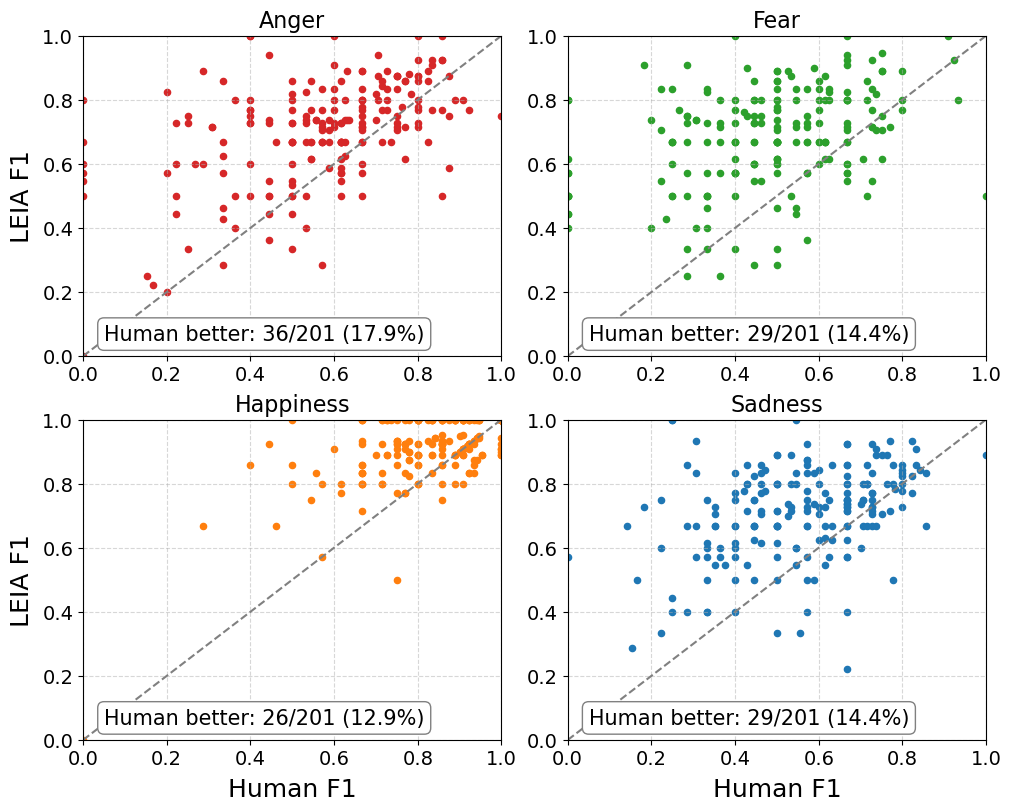

In [362]:
# fixed 4-colour palette
emotion_palette = ['#d62728',  # red
                   '#2ca02c',  # green
                   '#ff7f0e',  # orange
                   '#1f77b4']  # blue

emotion_colors = dict(zip(emotions, emotion_palette))
print(emotion_colors)

def scatter_paired_emotions(df, s=20, alpha=1, base_fs=18, tick_fs=14, text_fs=15):    
    """Create a paired scatter plot of F1_score per emotion for LEIA and Humans. 

    Args:
        df (dataframe): metrics per annotator
        s (int, optional): size of dots. Defaults to 20.
        alpha (int, optional): color fill value. Defaults to 1.
        base_fs (int, optional): adaptive fontisze. Defaults to 18.
        tick_fs (int, optional): tick fontsize. Defaults to 14.
        text_fs (int, optional): text fontsize. Defaults to 15.
        
    Retruns:
        plot and saves it as a pdf
    """

    fig, axes = plt.subplots(2, 2, figsize=(10, 8),  
                             constrained_layout=True)
    axes = axes.flatten()                             
    for i, (emotion, ax) in enumerate(zip(emotions, axes)):
        emotion_df = df[df['Emotion'] == emotion]

        # scatter points
        ax.scatter(emotion_df['F1-score'],
                   emotion_df['Leia_F1'],
                   alpha=alpha, s=s, color=emotion_colors[emotion] )  
        ax.plot([0, 1], [0, 1], ls='--', color='gray')

        # annotation: Human better count / %
        better = (emotion_df['F1-score'] > emotion_df['Leia_F1']).sum()
        total  = len(emotion_df)
        pct    = 100 * better / total
        ax.annotate(f'Human better: {better}/{total} ({pct:.1f}%)',
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    fontsize=text_fs,
                    bbox=dict(boxstyle='round,pad=0.30',
                              facecolor='white', edgecolor='gray'))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, ls='--', alpha=.5)
        ax.tick_params(axis='both', labelsize=tick_fs)

        ax.set_title(emotion, fontsize=text_fs+1, pad=6)

        # label logic 
        row, col = divmod(i, 2)  

        if col == 0:                            
            ax.set_ylabel('LEIA F1', fontsize=base_fs, labelpad=6)
        else:                                    
            ax.set_ylabel('')

        if row == 1:                              
            ax.set_xlabel('Human F1', fontsize=base_fs, labelpad=6)
        else:                                     
            ax.set_xlabel('')

    # save & display
    fig.savefig("../images/exp1-paired-scatter_emot.pdf",
                bbox_inches="tight", dpi=300)
    plt.show()


scatter_paired_emotions(metrics_per_annotator)


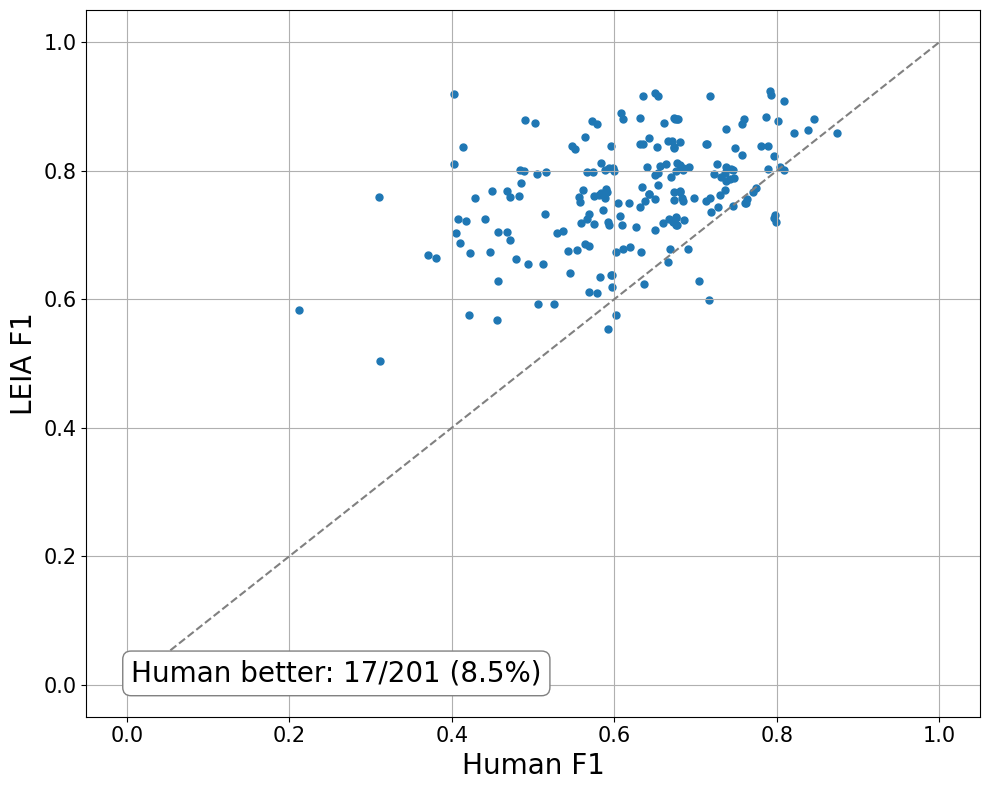

In [363]:

def scatter_paired(user_f1, Leia_F1, s=15, alpha=1):

    """Create a paired scatter plot of F1_score for LEIA and Humans. 

    Args:
        user_f1 (list): Human macro_f1 column per annotator sample
        Leia_F1 (list): LEIA macro_f1 column per annotator sample
        s (int, optional): size of dots. Defaults to 15.
        alpha (int, optional): color fill value. Defaults to 1.
       
    """

    plt.figure(figsize=(10, 8))
    plt.scatter(user_f1, Leia_F1, alpha=alpha, s=s, color='#1f77b4')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    better_count = sum(np.array(user_f1) > np.array(Leia_F1))
    total = len(user_f1)
    percentage = better_count / total * 100
    
    # Annotate the result
    plt.annotate(f'Human better: {better_count}/{total} ({percentage:.1f}%)',
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    fontsize=20,
                    bbox=dict(boxstyle='round,pad=0.30',
                              facecolor='white', edgecolor='gray'))

    plt.xlabel("Human F1", fontsize = 20)
    plt.ylabel("LEIA F1", fontsize = 20)

    plt.tick_params(labelsize=15)
    plt.grid(True)

    plt.tight_layout()

    plt.savefig("../images/exp1-paired-scatter.pdf",
                bbox_inches="tight", dpi=300)
    plt.show()


scatter_paired(macro_f1_anno['Macro F1-score'], macro_f1_anno['Leia Macro'], 'LEIA vs Participants paired Macro F1-scores', 25)


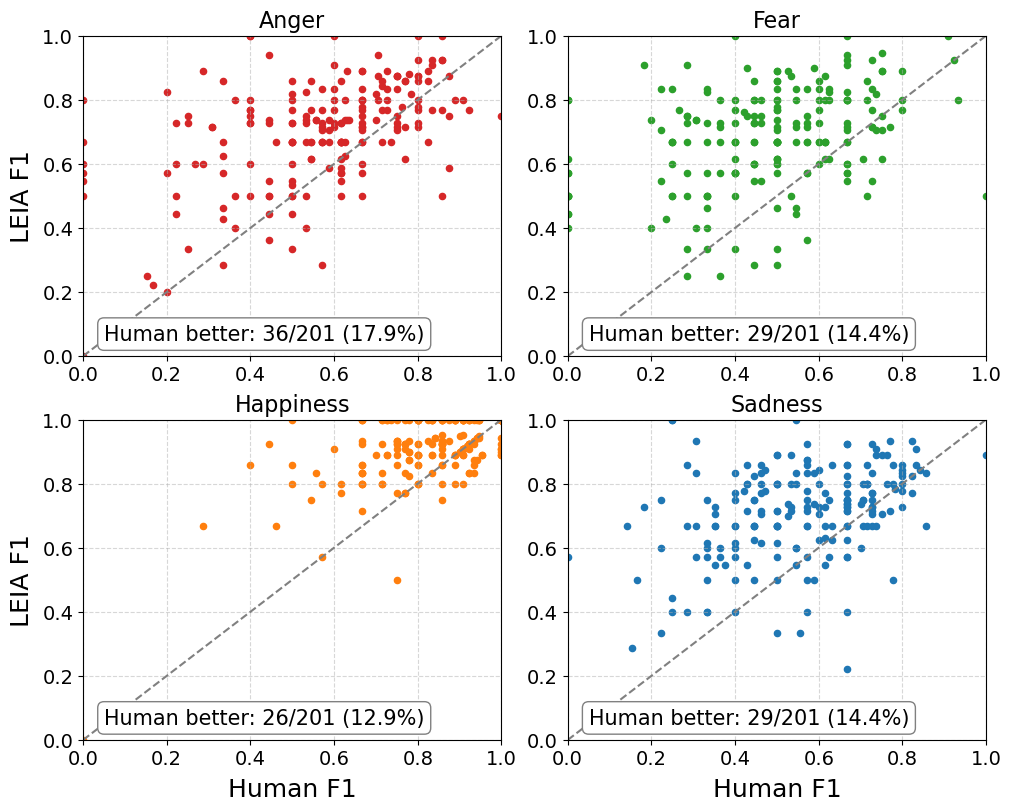

In [364]:
scatter_paired_emotions(metrics_per_annotator)




In [365]:
macro_f1_anno
macro_f1_anno['Difference'] = macro_f1_anno['Macro F1-score'] - macro_f1_anno['Leia Macro']

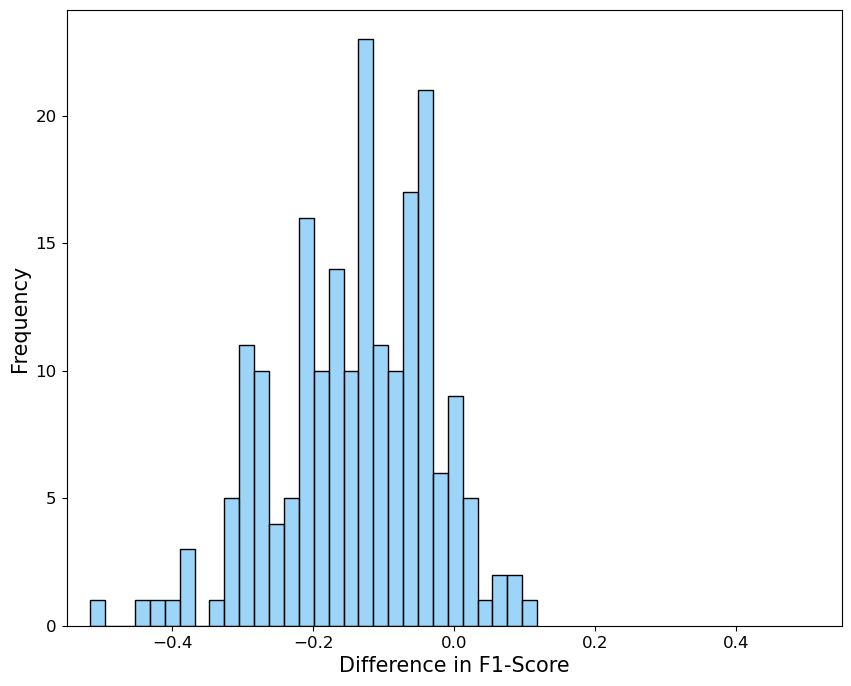

In [366]:
macro_f1_anno['Difference'] = macro_f1_anno['Macro F1-score'] - macro_f1_anno['Leia Macro']


plt.figure(figsize=(10, 8))

sns.histplot(macro_f1_anno['Difference'], bins=30, color='#7bc8f6')

plt.ylabel("Frequency", fontsize=15)
plt.tick_params(labelsize = 12)
plt.xlim(-0.55, 0.55)
plt.xlabel("Difference in F1-Score", fontsize=15)
plt.savefig("../images/diff_in_f1_exp1.pdf",
                bbox_inches="tight", dpi=300)
plt.show()



## Metrics without differentiating between individuals

In [367]:

def metrics(df, label_col):

    """Compute precision, recall, F1-score, and support for each emotion, along with macro averages.

    Args: 
        df: Dataframe with annotator as rows
        label_col: column containing predicted values
    Returns:
        per emotion dataframe, macro results and accuracy
    """
    y_true = df['true_label']
    y_pred = df[label_col]

    precision_vals, recall_vals, f1_vals, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=sorted(y_true.unique()), zero_division=0
    )

    emotions = sorted(y_true.unique())

    metrics_df = pd.DataFrame({
        'precision': precision_vals,
        'recall': recall_vals,
        'f1_score': f1_vals,
    }, index=emotions)

    macro_row = pd.DataFrame({
        'precision': [metrics_df['precision'].mean()],
        'recall': [metrics_df['recall'].mean()],
        'f1_score': [metrics_df['f1_score'].mean()],
    }, index=['Macro Average'])

    metrics_df = pd.concat([macro_row, metrics_df])

    acc = accuracy_score(y_true, y_pred)

    return metrics_df.round(3), macro_row['f1_score'].iloc[0], acc


annotator_per_emot, annotator_macro_f1, annotator_acc = metrics(annotator_df, 'label')
leia_per_emot, leia_macro_f1, leia_acc = metrics(annotator_df, 'Leia_Label')

leia_per_emot


,precision,recall,f1_score
Macro Average,0.773,0.766,0.767
Anger,0.690,0.748,0.718
Fear,0.780,0.640,0.703
Happiness,0.941,0.900,0.920
Sadness,0.681,0.776,0.725


In [368]:
annotator_per_emot

,precision,recall,f1_score
Macro Average,0.638,0.632,0.627
Anger,0.596,0.600,0.598
Fear,0.637,0.419,0.506
Happiness,0.808,0.862,0.834
Sadness,0.510,0.647,0.571


In [369]:
leia_acc, annotator_acc

(0.766, 0.6322)

In [370]:
anno_maj_per_emot, anno_maj_macro_f1, anno_maj_acc = metrics(anno_maj_aggr_emot, 'annotator_majority')

anno_maj_per_emot


,precision,recall,f1_score
Macro Average,0.688,0.676,0.670
Anger,0.645,0.640,0.643
Fear,0.717,0.436,0.542
Happiness,0.854,0.912,0.882
Sadness,0.538,0.716,0.614


In [371]:
sorted(leia_per_emot['f1_score'] - anno_maj_per_emot['f1_score'])


f1_diff = leia_per_emot['f1_score'] - annotator_per_emot['f1_score']

f1_diff = f1_diff.to_frame(name='F1_Difference')

print(f1_diff)


               F1_Difference
Macro Average          0.140
Anger                  0.120
Fear                   0.197
Happiness              0.086
Sadness                0.154


In [372]:
sorted(leia_per_emot['f1_score'] - anno_maj_per_emot['f1_score'])

f1_diff = leia_per_emot['f1_score'] - anno_maj_per_emot['f1_score']

f1_diff = f1_diff.to_frame(name='F1_Difference')

print(f1_diff)


               F1_Difference
Macro Average          0.097
Anger                  0.075
Fear                   0.161
Happiness              0.038
Sadness                0.111


In [373]:

label_dict = {
    'Humans': 'label',
    'LEIA': 'Leia_Label'}

group_order = {
    "Humans": ["Humans"],
    "Leia": ["LEIA"]}


group_base_colors = {
    'Humans': '#7bc8f6',     # blue
    'Leia': '#ffa500'}      # gold




def generate_similar_colors(base_hex, n):
    """Generate n visually distinct but similar colors from a base hex color."""
    base_rgb = mcolors.to_rgb(base_hex)
    base_hls = colorsys.rgb_to_hls(*base_rgb)

    colors = []
    for i in range(n):
        # Shift hue slightly to generate variations (±0.05 per step)
        hue_shift = (i - n // 2) * 0.05
        new_hue = (base_hls[0] + hue_shift) % 1.0
        # Keep lightness and saturation the same
        new_rgb = colorsys.hls_to_rgb(new_hue, base_hls[1], base_hls[2])
        colors.append(new_rgb)
    return colors

model_colors = {}

for group, readable_names in group_order.items():
    base_color = group_base_colors[group]
    n = len(readable_names)
    
    similar_colors = generate_similar_colors(base_color, n)
    for name, color in zip(readable_names, similar_colors):
        model_colors[name] = color




In [374]:

def bootstrap_f1_scores(df, label_dict, emotions, boot_n=10000, label_type="annotator"):
    """
    Bootstraps macro and per-emotion F1 scores for multiple models.

    Args:
        df (pd.DataFrame): Input DataFrame with 'true_label' and model prediction columns.
        label_dict (dict): Mapping from model name to prediction column name.
        emotions (list): List of emotion labels to evaluate.
        boot_n (int): Number of bootstrap samples.
        label_type (str): "annotator" or "majority" (for reference/logging only).

    Returns:
        macro_boot_results (dict): mean, lower, upper for macro F1 per model
        per_emotion_boot_results (dict): mean, lower, upper per emotion per model
        macro_boot_distributions (dict): list of macro F1 samples per model
        per_emotion_boot_distributions (dict): list of F1 samples per emotion per model
    """
    macro_boot_results = {}
    per_emotion_boot_results = {}

    macro_boot_distributions = {}
    per_emotion_boot_distributions = {}

    if label_type == 'majority':
        label_dict['Humans'] = 'annotator_majority'

    for model, label_col in tqdm(label_dict.items(), desc=f"Bootstrapping ({label_type})"):
        model_df = df.copy()
        model_df = model_df[~model_df[label_col].isna()]

        macro_scores = []
        emotion_scores = {e: [] for e in emotions}

        for _ in range(boot_n):
            boot_df = model_df.sample(frac=1, replace=True)

            try:
                macro = f1_score(boot_df['true_label'], boot_df[label_col], average='macro')
                macro_scores.append(macro)

                for emotion in emotions:
                    y_true = (boot_df['true_label'] == emotion).astype(int)
                    y_pred = (boot_df[label_col] == emotion).astype(int)

                    if y_true.sum() > 0:
                        emo_f1 = f1_score(y_true, y_pred)
                        emotion_scores[emotion].append(emo_f1)
            except Exception:
                continue

        # Save macro results and distribution
        macro_boot_results[model] = {
            "mean": np.mean(macro_scores),
            "lower": np.percentile(macro_scores, 2.5),
            "upper": np.percentile(macro_scores, 97.5)
        }
        macro_boot_distributions[model] = macro_scores

        # Save per-emotion results and distributions
        per_emotion_boot_results[model] = {}
        per_emotion_boot_distributions[model] = {}

        for emotion, scores in emotion_scores.items():
            per_emotion_boot_results[model][emotion] = {
                "mean": np.mean(scores),
                "lower": np.percentile(scores, 2.5),
                "upper": np.percentile(scores, 97.5)
            }
            per_emotion_boot_distributions[model][emotion] = scores

    return macro_boot_results, per_emotion_boot_results, macro_boot_distributions, per_emotion_boot_distributions


In [375]:

macro_boot_results_annotators, per_emotion_boot_results_annotators, macro_boot_distributions_annotators, per_emotion_boot_distributions_annotators= bootstrap_f1_scores(
df=annotator_df,
label_dict=label_dict,
emotions=emotions,
boot_n=10000,
label_type="annotator"
)


Bootstrapping (annotator): 100%|██████████| 2/2 [17:01<00:00, 510.80s/it]


In [376]:
macro_boot_distributions_annotators

{'Humans': [0.6296820978954009,
  0.6344690255414013,
  0.6338090272472241,
  0.6259380610414692,
  0.6343864257270685,
  0.6402989440756862,
  0.624501174187323,
  0.6295040415693276,
  0.6245933115458264,
  0.6131806828357358,
  0.6200365546804475,
  0.6251124853724026,
  0.6277232477368119,
  0.6144473541567014,
  0.6365516552125059,
  0.6306883143172398,
  0.6260572173815149,
  0.6353584944301113,
  0.6288908063103278,
  0.6199905038235252,
  0.6318104859247318,
  0.6221139884792221,
  0.6380699208866847,
  0.6313972096284612,
  0.6159848115678427,
  0.6156898155778819,
  0.625519868427501,
  0.6237226533079641,
  0.6348790836550242,
  0.6268984545747044,
  0.6277663243439703,
  0.620595471960524,
  0.6366339862816374,
  0.6086410245817361,
  0.6257111329347892,
  0.6150696571839925,
  0.6184227270193006,
  0.6287054705981892,
  0.6223874702275454,
  0.6333585302369816,
  0.6226506055717522,
  0.633175659456616,
  0.6322062557507636,
  0.6296017847451693,
  0.6287015616108378,
  0.

In [377]:

macro_boot_results_majority, per_emotion_boot_results_majority, macro_boot_distributions_majority, per_emotion_boot_distributions_majority= bootstrap_f1_scores(
df=anno_maj_aggr_emot,
label_dict=label_dict,
emotions=emotions,
boot_n=10000,
label_type="majority"
)


Bootstrapping (majority): 100%|██████████| 2/2 [05:58<00:00, 179.18s/it]


In [378]:
def prepare_f1_plot_data(per_emotion_boot_results, macro_boot_results, models):
    """
    Prepares F1 score values and confidence intervals for plotting.

    Returns:
        plot_data: dict with keys:
            - f1_plot_vals
            - yerr_lower
            - yerr_upper
            - x (positions)
            - emotions_with_avg
    """
    f1_plot_vals = {model: [] for model in models}
    yerr_lower = {model: [] for model in models}
    yerr_upper = {model: [] for model in models}

    emotions_with_avg = emotions + ["Macro Average"]
    x = np.arange(len(emotions_with_avg))

    for model in models:
        for emo in emotions:
            stats = per_emotion_boot_results[model][emo]
            mean = stats["mean"]
            lower = stats["lower"]
            upper = stats["upper"]

            f1_plot_vals[model].append(mean)
            yerr_lower[model].append(mean - lower)
            yerr_upper[model].append(upper - mean)

        macro_stats = macro_boot_results[model]
        macro_mean = macro_stats["mean"]
        macro_lower = macro_stats["lower"]
        macro_upper = macro_stats["upper"]

        f1_plot_vals[model].append(macro_mean)
        yerr_lower[model].append(macro_mean - macro_lower)
        yerr_upper[model].append(macro_upper - macro_mean)

    return {
        "f1_plot_vals": f1_plot_vals,
        "yerr_lower": yerr_lower,
        "yerr_upper": yerr_upper,
        "x": x,
        "emotions_with_avg": emotions_with_avg
    }


In [385]:
def plot_grouped_f1_bars_from_data(plot_data, models, model_labels=None, model_colors=None,
    save_path=None, figsize=(10, 6), bar_width=0.35, ylim=(0, 1.1)):
    
    """
    Plot grouped bar chart from precomputed plot data.
    
    """
    f1_plot_vals = plot_data["f1_plot_vals"]
    yerr_lower = plot_data["yerr_lower"]
    yerr_upper = plot_data["yerr_upper"]
    x = plot_data["x"]
    emotions_with_avg = plot_data["emotions_with_avg"]

    if model_labels is None:
        model_labels = {m: m for m in models}
    if model_colors is None:
        model_colors = {m: "gray" for m in models}

    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(models):
        offset = (i - 0.5) * bar_width
        bar_positions = x + offset

        bars = ax.bar(
            bar_positions,
            f1_plot_vals[model],
            width=bar_width,
            yerr=[yerr_lower[model], yerr_upper[model]],
            label=model_labels.get(model, model),
            color=model_colors.get(model, "gray"),
            edgecolor="black",
            capsize=5
        )

        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.055,
                f"{height:.2f}",
                ha="center", va="bottom", fontsize=15
            )

    ax.set_xticks(x)
    ax.set_xticklabels(emotions_with_avg, fontsize=15)
    ax.set_ylabel("F1 Score", fontsize=16)
    ax.set_ylim(*ylim)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(fontsize=13, frameon=False)



    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()


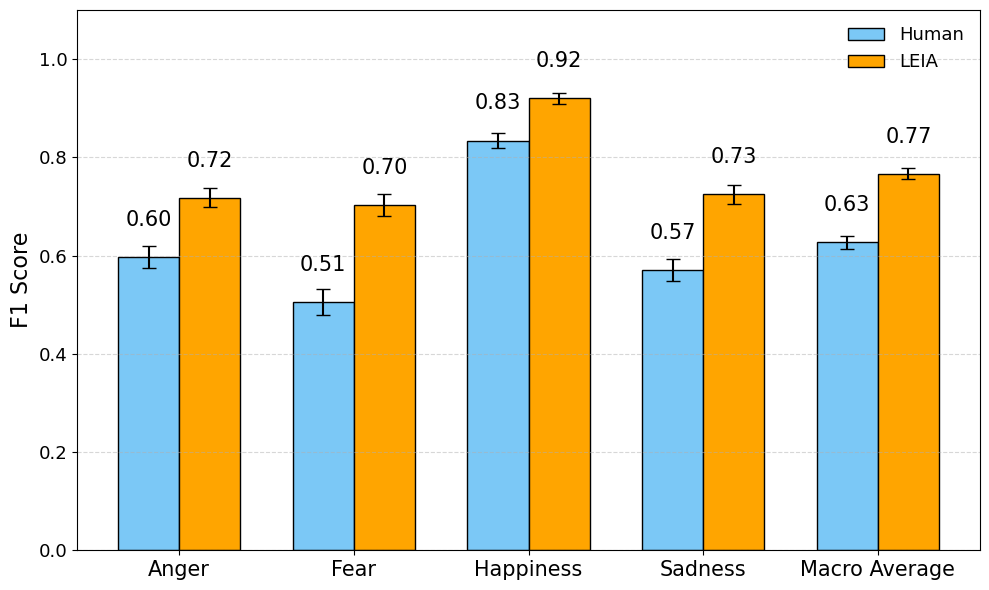

In [386]:
plot_data = prepare_f1_plot_data(
    per_emotion_boot_results=per_emotion_boot_results_annotators,
    macro_boot_results=macro_boot_results_annotators,
    models=["Humans", "LEIA"],
)

plot_grouped_f1_bars_from_data(
    plot_data,
    models=["Humans", "LEIA"],
    model_labels={"LEIA": "LEIA", "Humans": "Human"},
    model_colors=model_colors,
    save_path="../images/grouped_f1_scores.pdf",
)


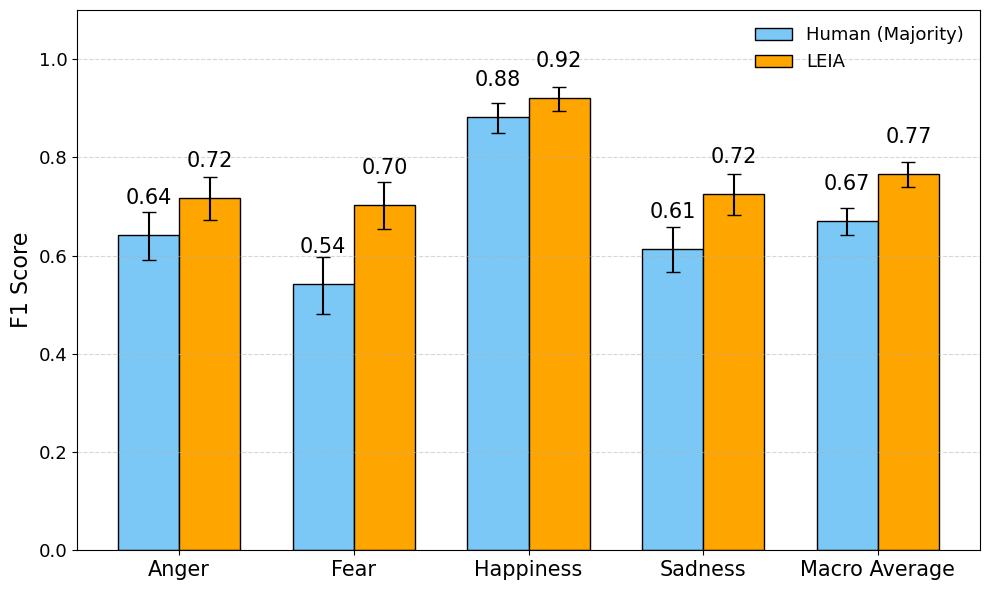

In [387]:
plot_data = prepare_f1_plot_data(
    per_emotion_boot_results=per_emotion_boot_results_majority,
    macro_boot_results=macro_boot_results_majority,
    models=["Humans", "LEIA"],
)

plot_grouped_f1_bars_from_data(
    plot_data,
    models=["Humans", "LEIA"],
    model_labels={"LEIA": "LEIA", "Humans": "Human (Majority)"},
    model_colors=model_colors,
    save_path="../images/grouped_f1_scores_majority.pdf",
)


#### 2.1.3 Visualizations

In [388]:
def macro_f1_dist_vs_leia_custom_layout(data_dict, type, fontsize = 20):

    """
    Plots 'Macro' distribution of bootstrapped values in the top row center and the 4 emotions in a 2x2 grid below.
    """
    emotion_items = [item for item in data_dict.items() if item[0] != "Macro"]

    if type =='annotators':
        human_label = 'Humans'
    else:
        human_label = 'Humans (Majority)'

    fig = plt.figure(constrained_layout=True, figsize=(18, 13))
    gs = fig.add_gridspec(3, 4)  


    # Macro F1 plot in the top row, centered
    ax_macro = fig.add_subplot(gs[0, 1:3])
    human_macro, leia_macro = data_dict["Macro"]
    sns.histplot(human_macro, kde=True, bins=30, color="#7bc8f6", label=human_label, ax=ax_macro)
    sns.histplot(leia_macro, kde=True, bins=30, color="#ffa500", label="Leia", ax=ax_macro)
    ax_macro.set_title("Macro F1-score", fontsize = fontsize)
    ax_macro.set_xlim(0.45, 1)
    ax_macro.set_xlabel("F1-score", fontsize = fontsize - 2)
    ax_macro.set_ylabel("Frequency", fontsize = fontsize - 2)
    ax_macro.tick_params(labelsize = fontsize)
    ax_macro.grid(True)
 
    # Emotion plots in a 2x2 grid below
    positions = [(1, 0), (1, 2), (2, 0), (2, 2)]
    for i, ((emotion, (human_f1, leia_f1)), (r, c)) in enumerate(zip(emotion_items, positions)):
        ax = fig.add_subplot(gs[r, c:c+2])
        sns.histplot(human_f1, kde=True, bins=20, color="#7bc8f6", ax=ax)
        sns.histplot(leia_f1, kde=True, bins=20, color="#ffa500", ax=ax)
        ax.set_title(f"{emotion}", fontsize=fontsize)
        ax.set_xlim(0.45, 1)

        
        if r == 2:
            ax.set_xlabel("F1-score", fontsize=fontsize - 2)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

        if c == 0:
            ax.set_ylabel("Frequency", fontsize=fontsize - 2)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        ax.tick_params(labelsize=fontsize-5)
        ax.grid(True)


    handles, labels = ax_macro.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.98),
        fontsize=fontsize,
        frameon=False
    )
    fig.savefig(f"../images/distribution_bootstrapped_f1-exp1-{type}.pdf", bbox_inches="tight")

    plt.show()


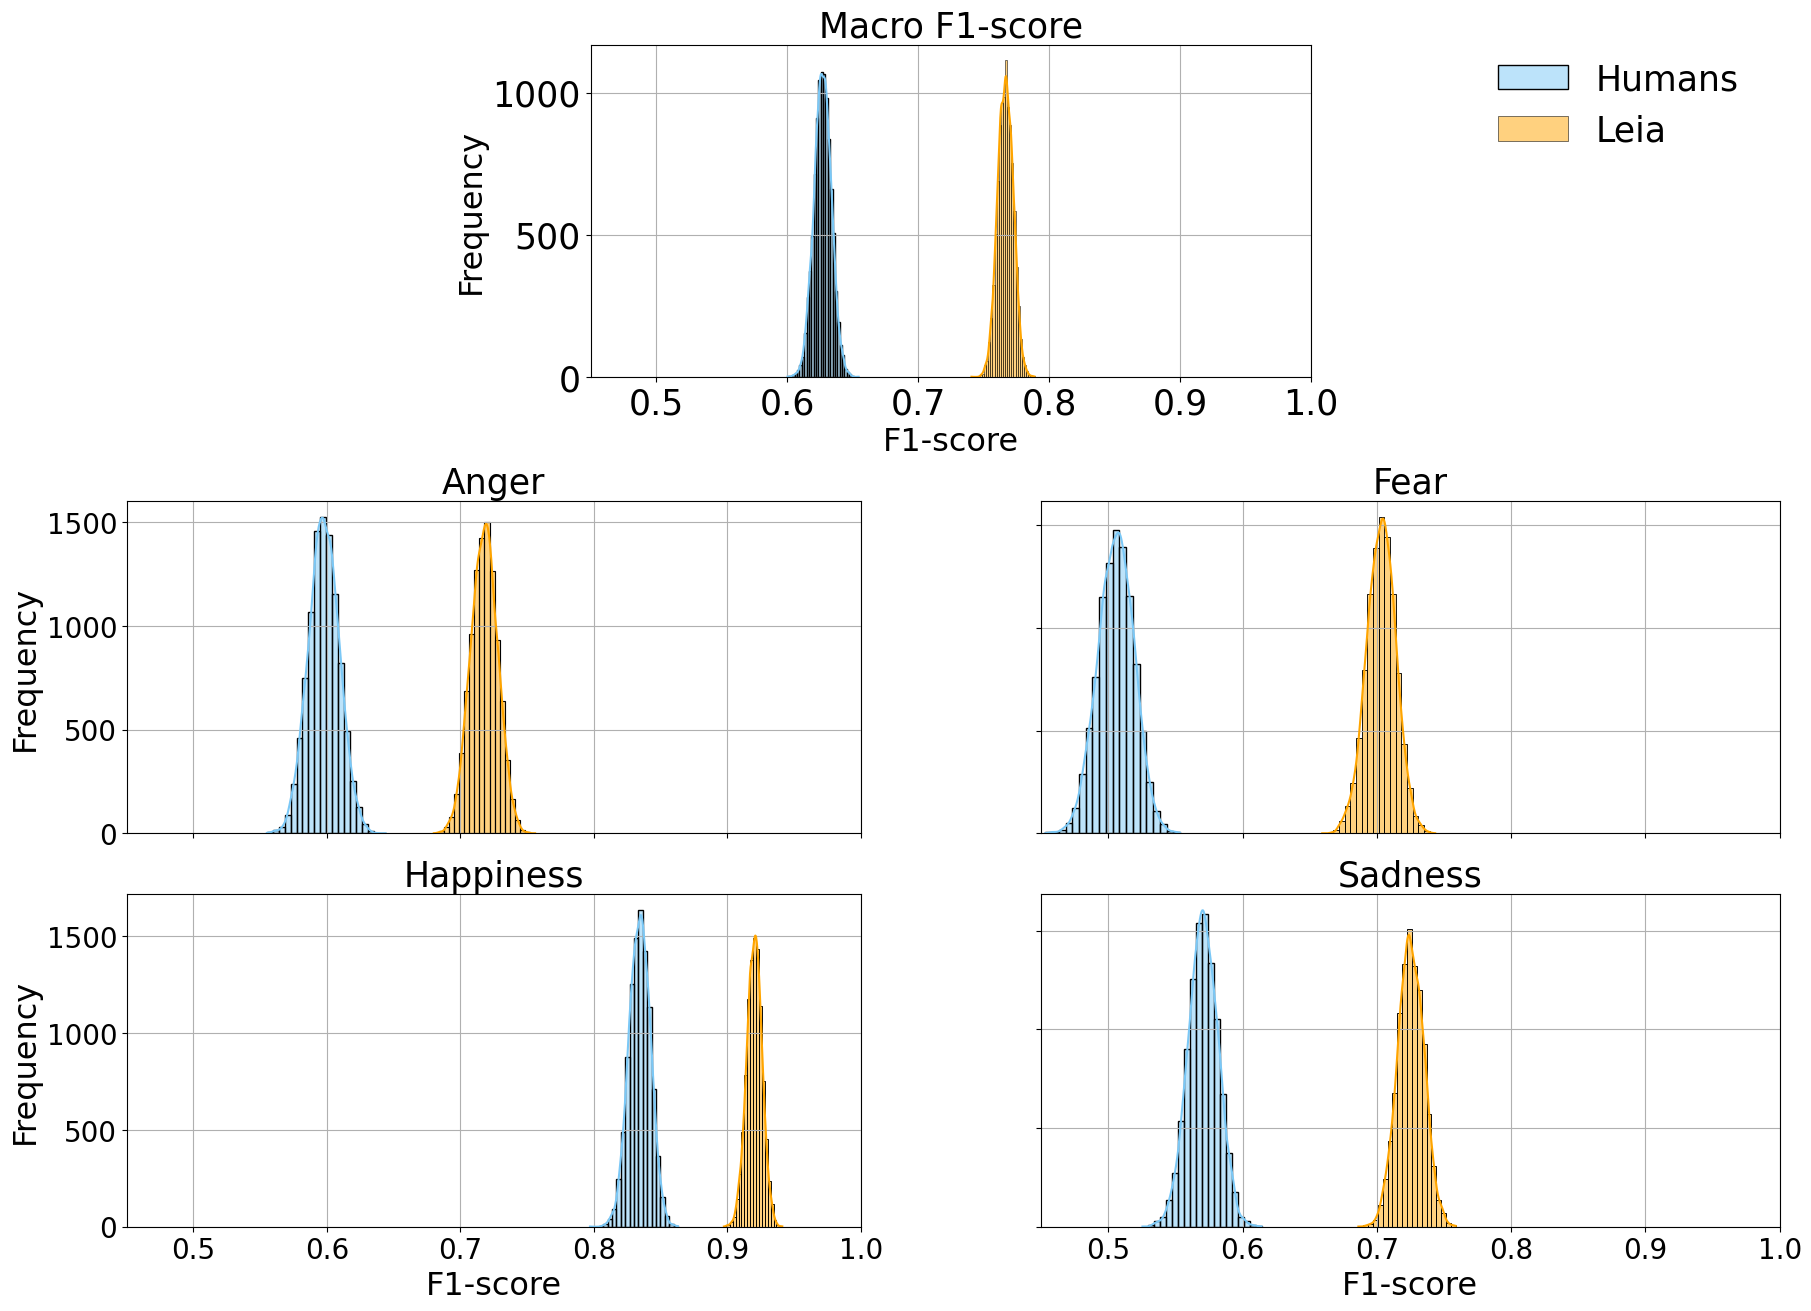

In [389]:
# Build the data dictionary
data_dict = {
    "Macro": (macro_boot_distributions_annotators['Humans'], macro_boot_distributions_annotators['LEIA'])
}
for emotion in emotions:
    human_vals = per_emotion_boot_distributions_annotators['Humans'][emotion]
    leia_vals = per_emotion_boot_distributions_annotators['LEIA'][emotion]
    data_dict[emotion] = (human_vals, leia_vals)

# Plot
macro_f1_dist_vs_leia_custom_layout(data_dict, 'annotators', 25)


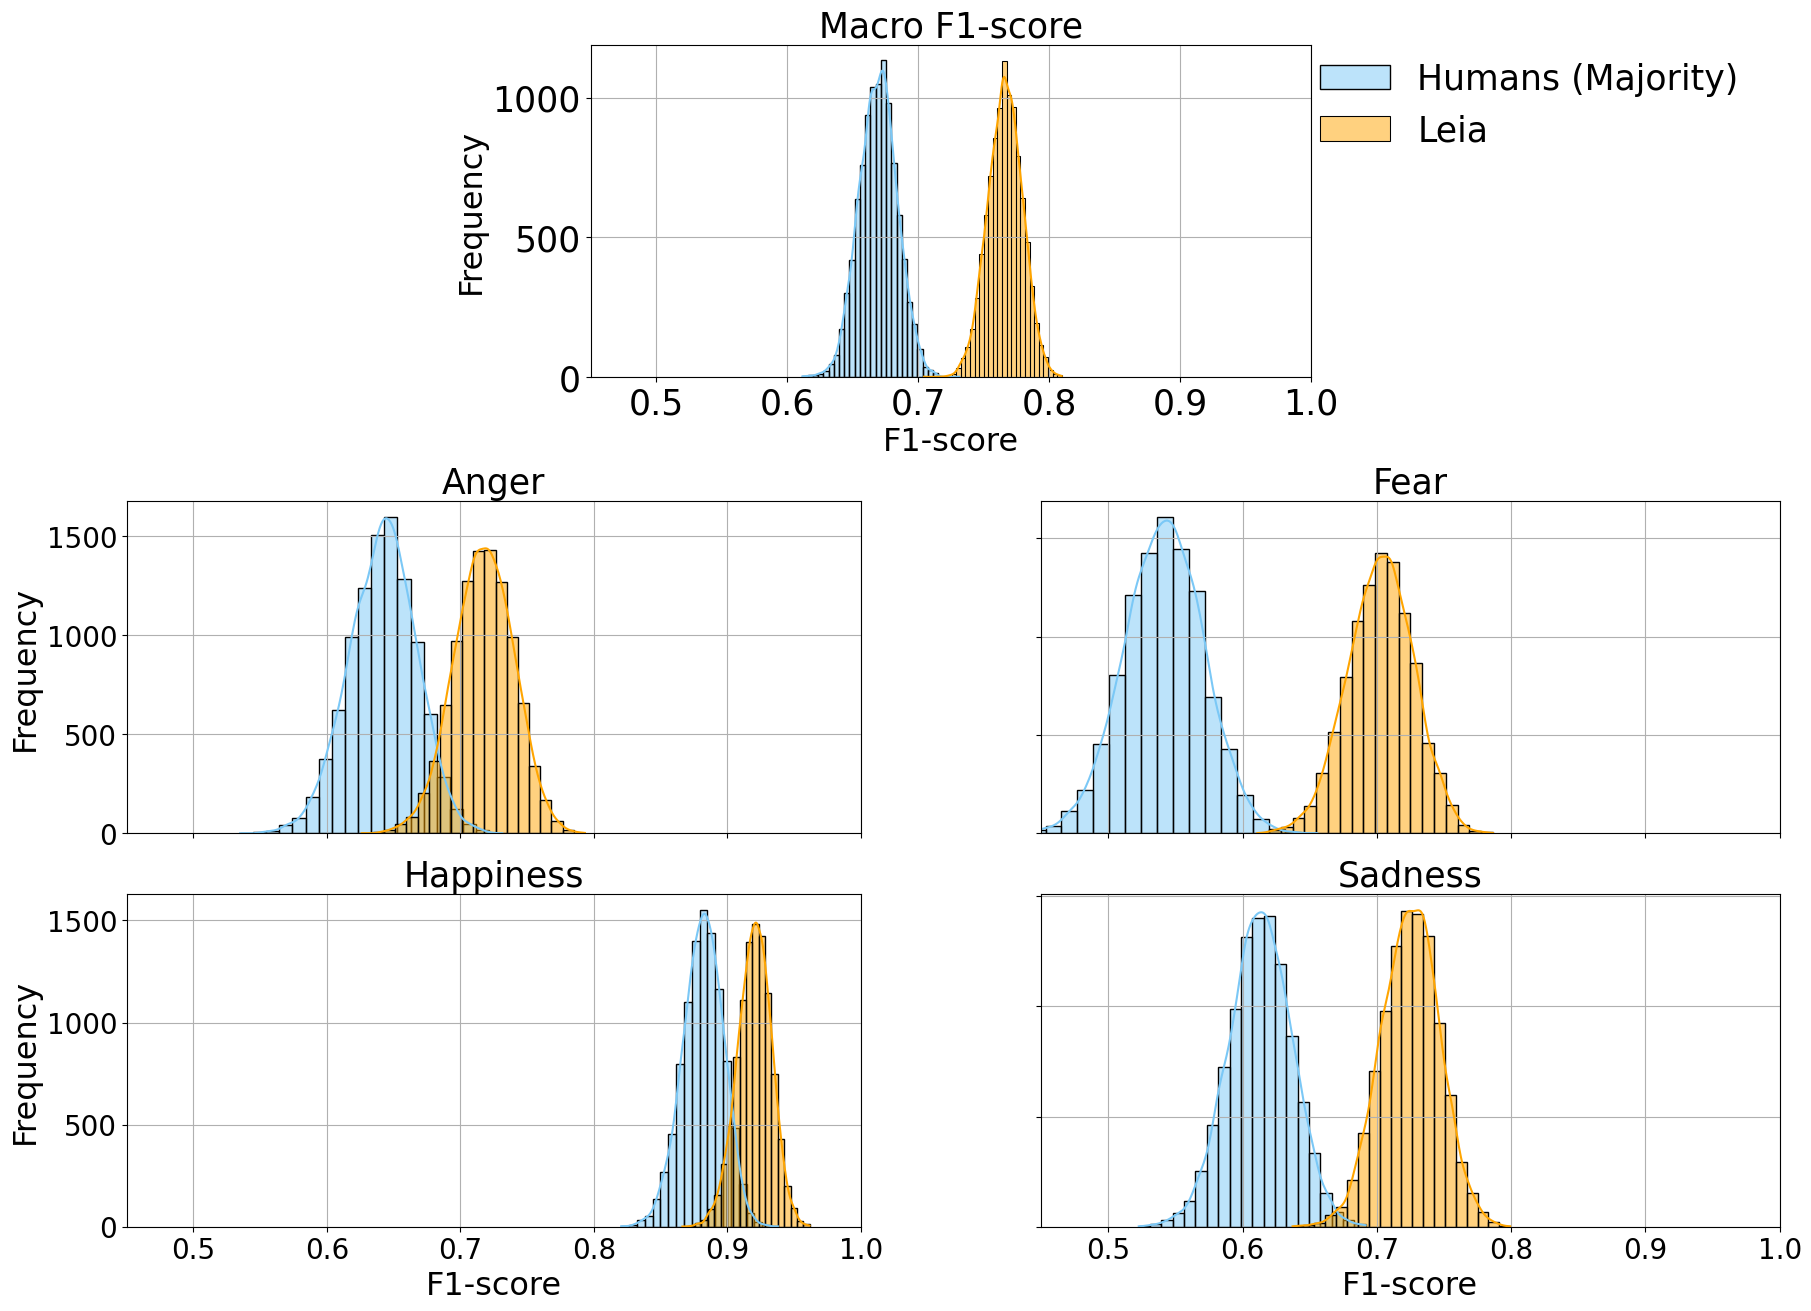

In [390]:
# Build the data dictionary
anno_maj_data_dict = {
    "Macro": (macro_boot_distributions_majority['Humans'], macro_boot_distributions_majority['LEIA'])
}
for emotion in emotions:
    human_vals = per_emotion_boot_distributions_majority['Humans'][emotion]
    leia_vals = per_emotion_boot_distributions_majority['LEIA'][emotion]
    anno_maj_data_dict[emotion] = (human_vals, leia_vals)

# Plot
macro_f1_dist_vs_leia_custom_layout(anno_maj_data_dict, 'majority', 25)


In [307]:
custom_palette ={'Humans': '#7bc8f6', 'LEIA': '#ffa500'}


In [391]:


records = []
for source, emo_dict in per_emotion_boot_distributions_annotators.items():
    for emotion, f1_list in emo_dict.items():
        for score in f1_list:
            records.append({
                "Source": source,
                "Emotion": emotion,
                "F1-score": score
            })

per_emotion_f1_df = pd.DataFrame(records)

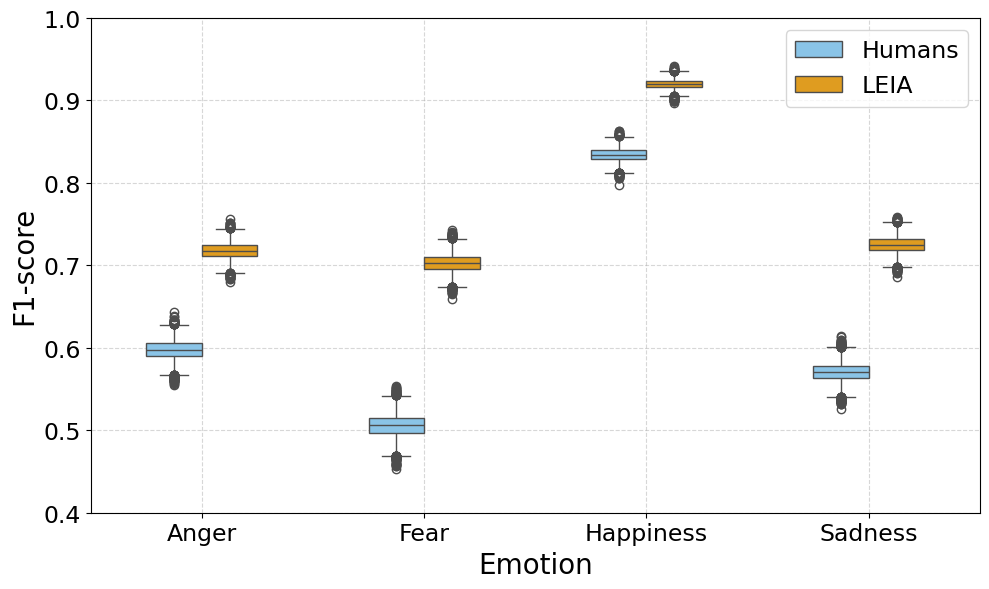

In [392]:

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Emotion', y='F1-score', data=per_emotion_f1_df, hue='Source', palette=custom_palette, width=0.5)

emotions = ['Anger', 'Fear', 'Happiness', 'Sadness']



plt.xlabel("Emotion", fontsize = 20)
plt.ylabel("F1-score",  fontsize = 20)
plt.ylim(0.4, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(labelsize= 17)
plt.legend( fontsize = 17)
plt.tight_layout()
plt.savefig(f"../images/boxplots-bootstrapped.pdf", bbox_inches="tight")

plt.show()


In [394]:
group_base_colors = {
    'Humans': '#7bc8f6',     # blue
    'LEIA': '#ffa500'}

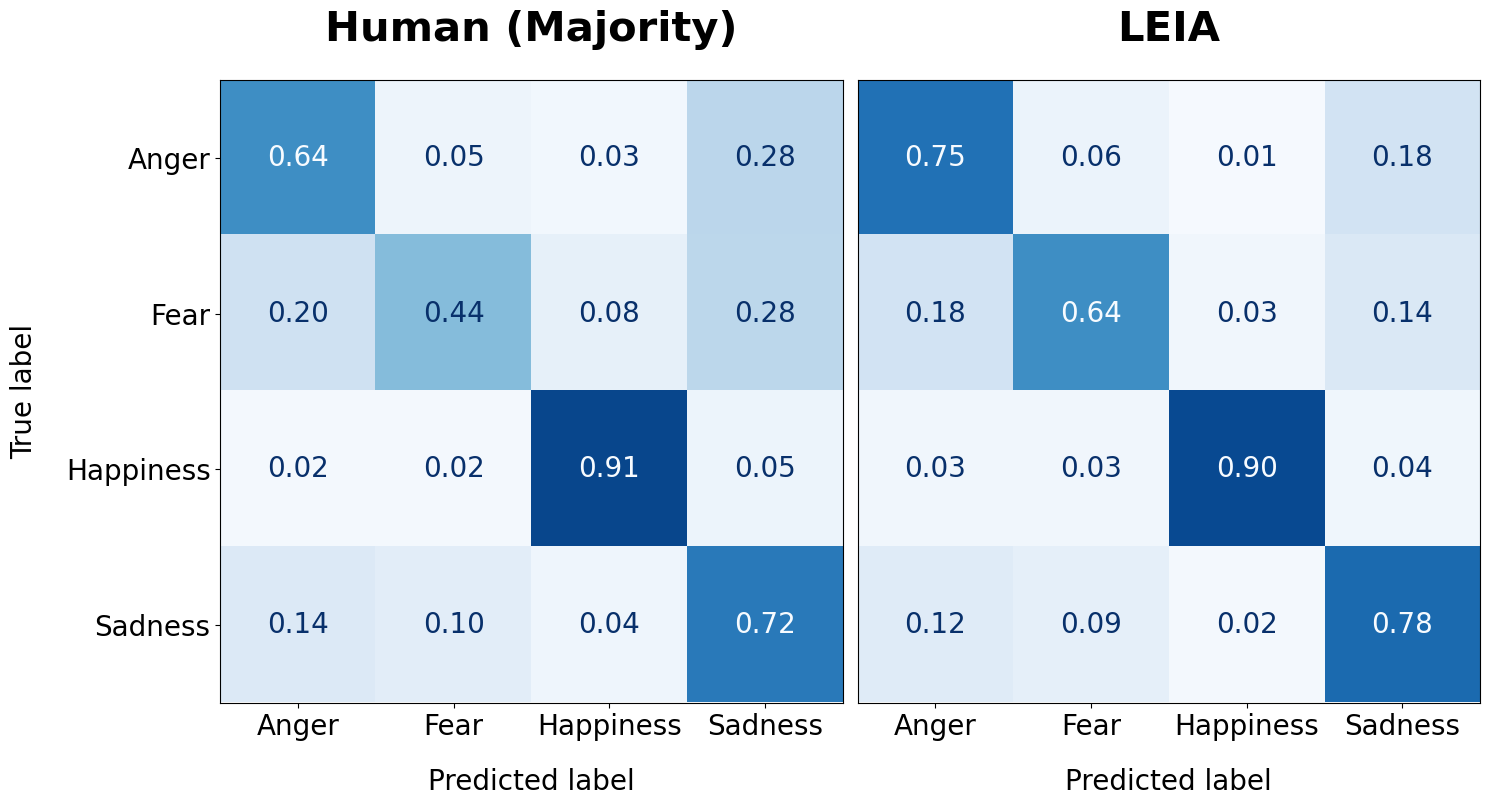

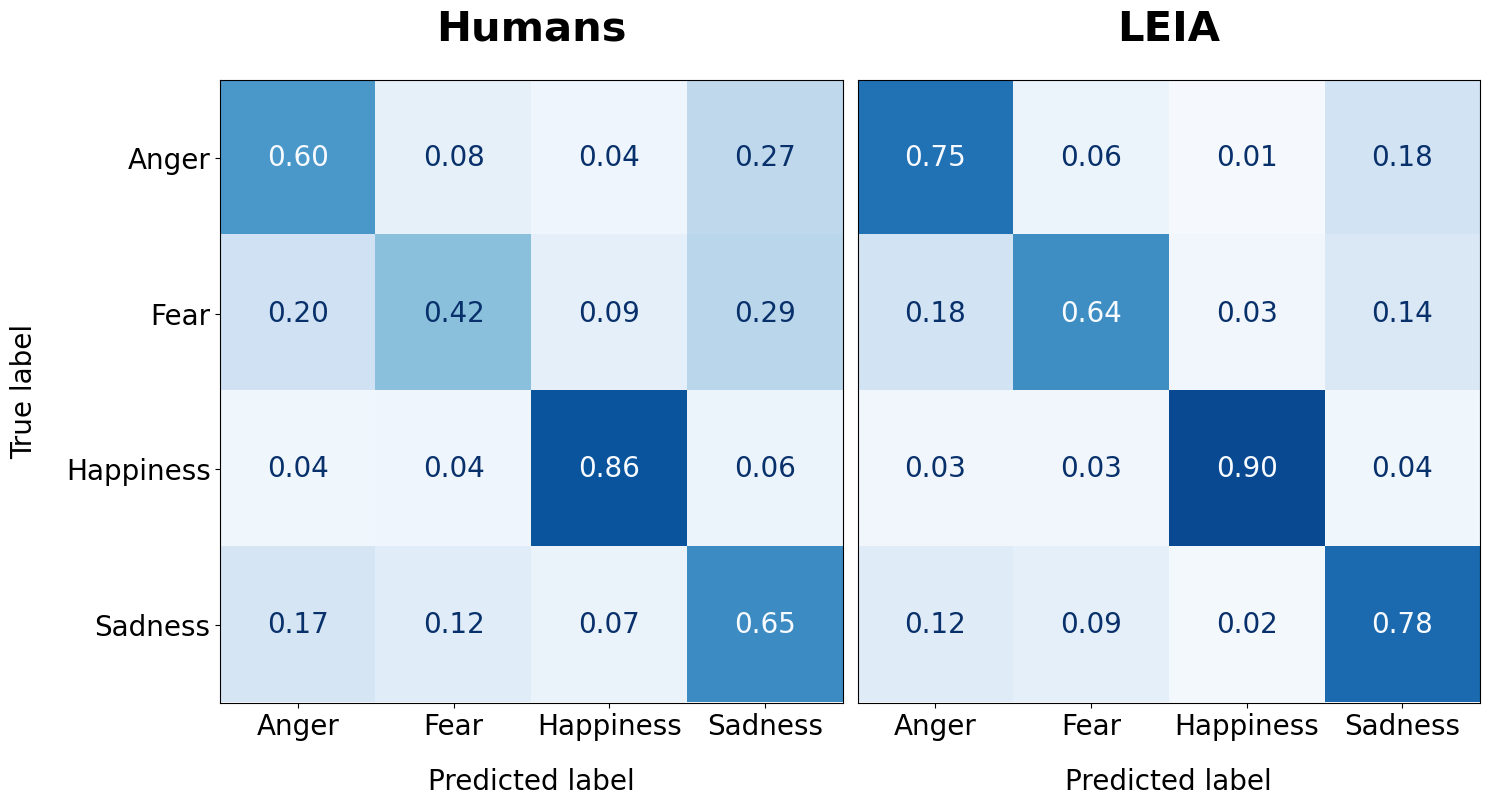

In [410]:

def confusion_matrix_plot(df, human_col: str, name: str,
                          base_fs=20, tick_fs=20, cell_fs=20):
    """
    Draws two normalised confusion matrices side by side.

    Parameters
    ----------
    base_fs : int
        Font size for axis labels & titles.
    tick_fs : int
        Font size for tick labels.
    cell_fs : int
        Font size for the numbers inside each cell.
    """

    # --- (1) create figure & axes ------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

    # --- (2) axis titles ---------------------------------------------------------
    ax1.set_title(name,        y=1.05, fontsize=base_fs+10,  weight="bold")
    ax2.set_title("LEIA",      y=1.05, fontsize=base_fs+10,  weight="bold")

    # --- (3) axis labels & ticks -------------------------------------------------
    for ax in (ax1, ax2):
        ax.set_xlabel("Predicted label", fontsize=base_fs, labelpad = 20)
        ax.set_ylabel("True label",      fontsize=base_fs, labelpad = 20)
        ax.tick_params(axis="both", labelsize=tick_fs)

    ax2.get_yaxis().set_visible(False)   # hide duplicate y-axis

    # --- (4) first confusion matrix ---------------------------------------------
    cm_human = confusion_matrix(df["true_label"], df[human_col],
                                normalize="true", labels=emotions)
    disp_h = ConfusionMatrixDisplay(cm_human, display_labels=emotions)
    disp_h.plot(ax=ax1, cmap="Blues", colorbar=False, values_format=".2f")
    disp_h.im_.set_clim(0, 1)

    # adjust cell-text size
    for txt in disp_h.text_.ravel():
        txt.set_fontsize(cell_fs)

    # --- (5) second confusion matrix --------------------------------------------
    cm_leia = confusion_matrix(df["true_label"], df["Leia_Label"],
                               normalize="true", labels=emotions)
    disp_l = ConfusionMatrixDisplay(cm_leia, display_labels=emotions)
    disp_l.plot(ax=ax2, cmap="Blues", colorbar=False, values_format=".2f")
    disp_l.im_.set_clim(0, 1)

    for txt in disp_l.text_.ravel():
        txt.set_fontsize(cell_fs)

    # --- (6) layout & save -------------------------------------------------------
    fig.tight_layout()
    fig.savefig(f"../images/exp1_confusion_matr_{human_col}.pdf",
                bbox_inches="tight", dpi=300)
    plt.show()

confusion_matrix_plot(anno_maj_aggr_emot, 'annotator_majority', 'Human (Majority)')
confusion_matrix_plot(annotator_df, 'label', 'Humans')


### 2.2 McNemar's test

In [400]:
def mcnemar_all_users_vs_leia(df, individual = True):

    """Calculating McNemar's test statistic for all humans (individual or majority) against LEIA

    Args: 
        df: dataframe used individual or majority
        individual (boolean): parameter to get correct column

    Returns:
        p_value: one-sided p-value of McNemar's test
        annotator_df: dataframe containing values of human or LEIA correct
        contingency_table: contigency table used to calculate McNemar's test
        mc_stat: Chi-squared and p_value
    """

    df = df.copy()
    df["Leia_Correct"] = (df["Leia_Label"] == df["true_label"]).astype(int)



    if individual:
        df["Human_Correct"] = (df["label"] == df["true_label"]).astype(int)
    else:
        df["Human_Correct"] = (df["annotator_majority"] == df["true_label"]).astype(int)


    
    contingency_table = np.zeros((2, 2))
    contingency_table[0, 0] = ((df["Human_Correct"] == 1) & (df["Leia_Correct"] == 1)).sum()  # Both correct
    contingency_table[0, 1] = ((df["Human_Correct"] == 0) & (df["Leia_Correct"] == 1)).sum()  # Model correct, human wrong (c)
    contingency_table[1, 0] = ((df["Human_Correct"] == 1) & (df["Leia_Correct"] == 0)).sum()  # Human correct, model wrong (b)
    contingency_table[1, 1] = ((df["Human_Correct"] == 0) & (df["Leia_Correct"] == 0)).sum()  # Both wrong

    b = contingency_table[1, 0]
    c = contingency_table[0, 1]
    if b + c > 0:
        if b + c > 25:
            result = mcnemar(contingency_table, exact=False)
        else:
            result = mcnemar(contingency_table, exact=True, correction=False)

        # One-tailed p-value (is Leia better?)
        if c > b:
            one_tailed_p = result.pvalue / 2
        else:
            one_tailed_p = 1.0

        return one_tailed_p, df, contingency_table, result
    else:
        return "No disagreements between humans and Leia, McNemar's test not applicable."

    

p_val, annotator_df, contingency_table, mc_stat = mcnemar_all_users_vs_leia(annotator_df)
print(mc_stat)
p_val


pvalue      2.1787981516249584e-82
statistic   369.6967688483844


1.0893990758124792e-82

In [399]:
anno_maj_p_val, anno_maj_aggr_emot, anno_maj_contingency_table, testing_result = mcnemar_all_users_vs_leia(anno_maj_aggr_emot, individual=False)
anno_maj_p_val

9.823179011908946e-12

In [403]:
anno_maj_contingency_table

array([[633., 133.],
       [ 43., 191.]])

In [402]:
print(testing_result)

pvalue      1.9646358023817893e-11
statistic   45.00568181818182


2.096122

In [401]:
testing_result.pvalue/2

9.823179011908946e-12

In [ ]:
def mcnem_per_participant(annotators, restructured_results):

    """McNemar's test per participant on respective sample

    Returns:
        dataframe: dataframe with McNemar's results per participants
        dictionary: contigency tables per participant
    """

    mcnemar_results = {}
    user_cont_tables = {}

    for user in annotators:
        user_df = restructured_results[restructured_results["user_id"] == user]

        contingency_table = np.zeros((2, 2))
        contingency_table[0, 0] = ((user_df["Human_Correct"] == 1) & (user_df["Leia_Correct"] == 1)).sum()  # Both correct
        contingency_table[0, 1] = ((user_df["Human_Correct"] == 0) & (user_df["Leia_Correct"] == 1)).sum()  # Model correct, human wrong (c)
        contingency_table[1, 0] = ((user_df["Human_Correct"] == 1) & (user_df["Leia_Correct"] == 0)).sum()  # Human correct, model wrong (b)
        contingency_table[1, 1] = ((user_df["Human_Correct"] == 0) & (user_df["Leia_Correct"] == 0)).sum()  # Both wrong

        result = mcnemar(contingency_table)#, exact=True, correction=True)
        
        # One-tailed p-value adjustment
        b, c = contingency_table[1, 0], contingency_table[0, 1]

        if contingency_table[0, 1] + contingency_table[1, 0] > 0:


            if b + c > 25:
                result = mcnemar(contingency_table, exact=False)
            else:
                result = mcnemar(contingency_table, exact=True, correction=False)
            if c > b:
                one_tailed_p = result.pvalue / 2  # Model performs better
            else:
                one_tailed_p = 1  # Humans perform better, force non-significance

        mcnemar_results[user] = {
            "p-value": round(one_tailed_p, 5), 
            "statistic": result.statistic
        }
        user_cont_tables[user] = contingency_table

    mcnemar_df = pd.DataFrame.from_dict(mcnemar_results, orient="index")

    return mcnemar_df, user_cont_tables

mcnemar_by_participant, participant_contingency_tables = mcnem_per_participant(annotators, annotator_df)

mcnemar_by_participant


In [405]:
significance_level = 0.05

significant_leia_wins = mcnemar_by_participant[
    (mcnemar_by_participant["p-value"] < significance_level) &
    (mcnemar_by_participant.index.map(lambda user: participant_contingency_tables[user][0, 1] > participant_contingency_tables[user][1, 0]))  # LEIA better
]

num_leia_wins = len(significant_leia_wins)
total_participants = len(mcnemar_by_participant)
percentage_leia_wins = (num_leia_wins / total_participants) * 100

print(f"LEIA performs significantly better than the human annotators in {num_leia_wins} out of {total_participants} cases.")
print(f"That's about {percentage_leia_wins:.2f}% of the participants.")


LEIA performs significantly better than the human annotators in 46 out of 201 cases.
That's about 22.89% of the participants.


In [406]:
def mcnemar_per_emot(emotions, restructured_results):

    """Calculating McNemar's test statistic for all humans against LEIA per emotion

    Args: 
        annotator: list of annotators
        restructured_results (dataframe): dataframe with annotator as rows

    Returns:
        dataframe of McNemar's test results per emotion
        contingency tables(dictionary): per emotion
    """
    
    mcnemar_results = {}
    contingency_tables = {}

    for emotion in emotions:
        df_emotion = restructured_results[restructured_results["true_label"] == emotion]
        
        contingency_table = np.zeros((2, 2))
        contingency_table[0, 0] = ((df_emotion["Human_Correct"] == 1) & (df_emotion["Leia_Correct"] == 1)).sum()  # Both correct
        contingency_table[0, 1] = ((df_emotion["Human_Correct"] == 0) & (df_emotion["Leia_Correct"] == 1)).sum()  # Model correct, human wrong (c)
        contingency_table[1, 0] = ((df_emotion["Human_Correct"] == 1) & (df_emotion["Leia_Correct"] == 0)).sum()  # Human correct, model wrong (b)
        contingency_table[1, 1] = ((df_emotion["Human_Correct"] == 0) & (df_emotion["Leia_Correct"] == 0)).sum()  # Both wrong
        #contingency_tables[emotion] = np.array(contingency_table)
        if contingency_table[0, 1] + contingency_table[1, 0] > 0:

                b, c = contingency_table[1, 0], contingency_table[0, 1]

                if b + c > 25:
                    result = mcnemar(contingency_table, exact=False)
                else:
                    result = mcnemar(contingency_table, exact=True, correction=False)
        contingency_tables[emotion] = np.array(contingency_table)

        
        # One-tailed p-value adjustment
        b, c = contingency_table[1, 0], contingency_table[0, 1]
        if c > b:
            one_tailed_p = result.pvalue / 2  # Model performs better
        else:
            one_tailed_p = 1  # Humans perform better, force non-significance

        mcnemar_results[emotion] = {
            "p-value": round(one_tailed_p, 5), 
            "statistic": result.statistic
        }

    mcnemar_df = pd.DataFrame.from_dict(mcnemar_results, orient="index")

    return mcnemar_df, contingency_tables

mcnemar_per_emotion_df, emot_contingency_tables = mcnemar_per_emot(emotions, annotator_df)
emot_contingency_tables


{'Anger': array([[678., 257.],
        [ 72., 243.]]),
 'Fear': array([[455., 345.],
        [ 69., 381.]]),
 'Happiness': array([[1040.,   85.],
        [  38.,   87.]]),
 'Sadness': array([[719., 251.],
        [ 90., 190.]])}

In [407]:
mcnemar_per_emotion_df

,p-value,statistic
Anger,0.00000,102.905775
Fear,0.00000,182.669082
Happiness,0.00002,17.203252
Sadness,0.00000,75.073314


In [408]:
mcnemar_per_emotion_df, emot_contingency_tables = mcnemar_per_emot(emotions, anno_maj_aggr_emot)
emot_contingency_tables


{'Anger': array([[146.,  41.],
        [ 14.,  49.]]),
 'Fear': array([[101.,  59.],
        [  8.,  82.]]),
 'Happiness': array([[221.,   4.],
        [  7.,  18.]]),
 'Sadness': array([[165.,  29.],
        [ 14.,  42.]])}

In [328]:
mcnemar_per_emotion_df

,p-value,statistic
Anger,0.00213,8.166667
Fear,0.00000,38.250000
Happiness,1.00000,5.000000
Sadness,0.01992,4.225000
